In [1]:
%pip install pendulum praw requests

Note: you may need to restart the kernel to use updated packages.


In [333]:
pip install --upgrade praw

Note: you may need to restart the kernel to use updated packages.


In [3]:
import praw
import pandas as pd
from datetime import datetime
import requests
import pendulum

pid = "jiayizhang"

In [5]:
#To use this you'll need a reddit account and create a script app here: https://old.reddit.com/prefs/apps
#then set the client_id and client_secret below.

reddit = praw.Reddit(
    client_id="UkNyXFehnUPkYb7GMfIQDw",
    client_secret="DMjDKELxsGcd2w4HiVUUPrid2SJqAw",
    user_agent='testscript by /u/' + pid
)

In [6]:
print(reddit.read_only)

True


In [324]:
# # find the reddit posts&comments by given date
# # return [[submissions], [comments]]

def searchByData_ym(year, month, reddit):
    start=datetime(year,month,1).timestamp()
    if month>=12:
        year += 1
        month = 1
    else:
        month += 1
    end=datetime(year, month, 1).timestamp()
    commentDataset=[]
    submissionDataset=[]
    for submission in reddit.subreddit("RealEstate").search("climate change"):
        if submission.created_utc >= start and submission.created_utc <= end:
            submissionDataset.append(submission)
            # new versions of praw
            submission.comments.replace_more(limit=0) # flatten tree
            comments = submission.comments.list() # all comments
            commentDataset += comments
    return submissionDataset, commentDataset

In [365]:
# use nltk module
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np

# Create data frame with label
def label_sentiment(row):
    cutoff = .5
    if row.compound < -1 * cutoff:
        return "neg"
    elif row.compound > cutoff:
        return "pos"
    else:
        return "neu"

# monthly sentiment analysis 
def sentiAnalyze(comment):
    # Generate English stopwords
    sws = set(stopwords.words('english'))
    sid = SentimentIntensityAnalyzer()
    comments_text = []
    scores = []
    for c in comment:
        words = nltk.word_tokenize(c.body)
        filtered_sentence = [w for w in words if not w.lower() in sws]
    
        parsed_sent_eng = ' '.join(filtered_sentence)
    
        comments_text += [parsed_sent_eng]
    
        data = sid.polarity_scores(parsed_sent_eng)
    
        data['comment'] = parsed_sent_eng
        scores += [data]
    
    # Create data frame for sentiment scores
    dataFrame = pd.DataFrame(scores)
    dataFrame["label"] = dataFrame.apply(label_sentiment, axis=1)
    
    # Sentiment analysis count and percentage 
    result = [len(dataFrame[dataFrame["label"] == 'pos'])/len(dataFrame), len(dataFrame[dataFrame["label"] == 'neg'])/len(dataFrame), len(dataFrame[dataFrame["label"] == 'neu'])/len(dataFrame)]
    
    return result
    

monthlySentiment = []
for year in range(2020, 2023):
    for month in range(1, 13):
        posts, comments = searchByData_ym(year, month, reddit)
#         for c in comments:
#             print(c.body)
        if comments:
            # analyze comments
            results = ["{}-{}".format(year, month)] + sentiAnalyze(comments)
            monthlySentiment.append(results)

        
df = pd.DataFrame(np.array(monthlySentiment), columns=['year-month', 'pos', 'neg', 'neu'])
df

,year-month,pos,neg,neu
0,2020-3,0.16666666666666666,0.16666666666666666,0.6666666666666666
1,2020-4,0.29411764705882354,0.058823529411764705,0.6470588235294118
2,2020-5,0.4166666666666667,0.08333333333333333,0.5
3,2020-7,0.23529411764705882,0.11764705882352941,0.6470588235294118
4,2020-8,0.5,0.13636363636363635,0.36363636363636365
5,2020-9,0.34782608695652173,0.13043478260869565,0.5217391304347826
6,2020-10,0.375,0.0625,0.5625
7,2020-11,0.8181818181818182,0.09090909090909091,0.09090909090909091
8,2020-12,0.47692307692307695,0.07692307692307693,0.4461538461538462
9,2021-2,0.2727272727272727,0.13636363636363635,0.5909090909090909


In [83]:
type(df['pos'][0])

str

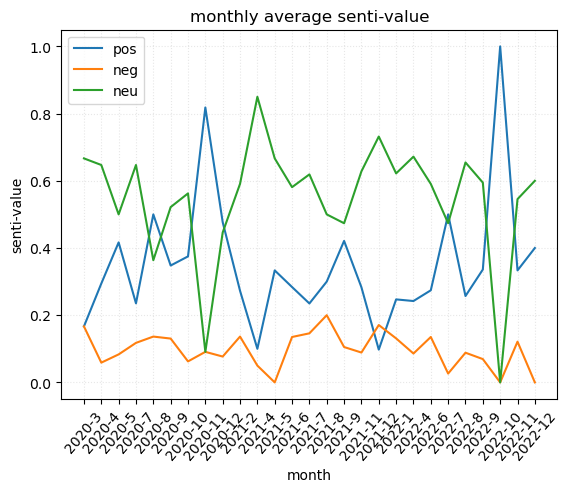

In [290]:
import matplotlib.pyplot as plt

y_pos=df['pos'].astype(float)
y_neg=df['neg'].astype(float)
y_neu=df['neu'].astype(float)
x=df['year-month']

plt.xticks(rotation=50)

plt.grid(alpha=0.3,linestyle=':')

plt.xlabel('month')
plt.ylabel('senti-value')

plt.plot(x,y_pos,label='pos')
plt.plot(x,y_neg,label='neg')
plt.plot(x,y_neu,label='neu')

plt.legend()
plt.title('monthly average senti-value')
plt.savefig('monthly.png', bbox_inches='tight')
plt.show()


In [143]:
import nltk
from gensim import corpora, models
from collections import Counter
from stop_words import get_stop_words
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import re
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import networkx as nx
import warnings

In [325]:

# 找指定日期内的reddit数据
# return [[submissions], [comments]]
def searchByData(start, end, reddit):
    start=datetime(start,1,1).timestamp()
    end=datetime(end,1,1).timestamp()
    commentDataset=[]
    submissionDataset=[]
    for submission in reddit.subreddit("RealEstate").search("climate change"):
        if submission.created_utc >= start and submission.created_utc <= end:
            submissionDataset.append(submission.selftext)
            # new versions of praw
            submission.comments.replace_more(limit=0) # flatten tree
            comments = submission.comments.list() # all comments
            commentDataset += comments
    return submissionDataset, commentDataset

In [460]:
###### Part 2 ###############################################
#Generate topic clusters from the post and comment text data#
#############################################################

posts, comments = searchByData(2020, 2023, reddit)

# posts to data frame
df_posts = pd.DataFrame(np.array(posts), columns=['posts'])

# comments to dataframe
c=[]
for co in comments:
    c.append(co.body)
df_comment = pd.DataFrame(np.array(c), columns=['comments'])

In [461]:
df_comment

,comments
0,[deleted]
1,"Yes. Access to fresh water, land, ability to h..."
2,"Finger Lakes, upstate NY. Fresh water, arable ..."
3,Yes. I would not move somewhere that is at ris...
4,Minnesota probably benefits from climate chang...
...,...
3443,Turn on the utilities so there isn't any unexp...
3444,This is so odd to me I was clear to close and ...
3445,I would definitely turn the utilities on. We w...
3446,Thank you all for the advice! I will turn on t...


In [473]:
df_posts

,posts
0,
1,Has climate change concerns affected your choi...
2,Anyone else notice that the areas in the US wi...
3,"Hey all,\n\nI'm interested in potentialy getti..."
4,So me and the wife have been talking about buy...
5,I know real estate/real estate income is consi...
6,"Situation: Partner and I have a 2.5yo, we also..."
7,I know we love to debate bubble vs no bubble h...
8,Given California is large and has different cl...
9,Prediction #1: Mortgage rates will rise to 3.6...


In [462]:
# Topic Modeling - Comments
all_docs = df_comment['comments'].values
exclude = set(string.punctuation)
tokenized = []

for doc in all_docs:
    doc = geNormalizedText(doc)
    tokens = nltk.word_tokenize(doc.lower())
    tokenized.append(''.join([ch for ch in ' '.join(tokens) if ch not in exclude]).split())

In [463]:
def geNormalizedText(string):
    string = string.lower()
    string = re.sub(r'[^\w\s]|\d+|\b\w{1,2}\b',' ',string)
    string = ' '.join(set(string.split())-set(get_stop_words("english")))
    string = string.replace('http', '')
    string = string.replace('www', '')
    string = string.replace('climate', '')
    string = string.replace('housing', '')
    string = string.replace('house', '')
    string = string.replace('home', '')
    string = string.replace('real estate', '')
    return string

In [464]:
tokenized

[['deleted'],
 ['garden', 'water', 'yes', 'land', 'solar', 'ability', 'fresh', 'access'],
 ['knows',
  'plant',
  'finger',
  'food',
  'lakes',
  'water',
  'maybe',
  'land',
  'production',
  'fresh',
  'arable',
  'vineyard',
  'upstate',
  'local'],
 ['move',
  'future',
  'somewhere',
  'scarcity',
  'water',
  'yes',
  'due',
  'now',
  'risk',
  'change'],
 ['minnesota', 'probably', 'mild', 'imagine', 'benefits', 'winters', 'change'],
 ['buy',
  'usually',
  'counties',
  'yes',
  'factors',
  'looking',
  'projects',
  'different',
  'bottom',
  'add',
  'point',
  'feel',
  'drought',
  'wanted',
  'property',
  'nearsighted',
  'impacted',
  'access',
  'something',
  'org',
  'areas',
  'water',
  'decades',
  'grow',
  'showing',
  'migration',
  'affected',
  'change',
  'desert',
  'comes',
  'ready',
  'food',
  'life',
  'confident',
  'propublica',
  'link',
  'next',
  'selling',
  'future',
  'can',
  'list',
  'likely',
  's',
  'now',
  'edit',
  'less'],
 ['state

In [465]:
dictionary = corpora.Dictionary(tokenized)
dictionary.filter_extremes(no_below=5, no_above=0.3)
dictionary.compactify()

In [466]:
print(dictionary.token2id)

{'deleted': 0, 'ability': 1, 'access': 2, 'fresh': 3, 'garden': 4, 'land': 5, 'solar': 6, 'water': 7, 'yes': 8, 'food': 9, 'knows': 10, 'lakes': 11, 'local': 12, 'maybe': 13, 'plant': 14, 'production': 15, 'upstate': 16, 'change': 17, 'due': 18, 'future': 19, 'move': 20, 'now': 21, 'risk': 22, 'somewhere': 23, 'benefits': 24, 'imagine': 25, 'mild': 26, 'minnesota': 27, 'probably': 28, 'winters': 29, 'add': 30, 'affected': 31, 'areas': 32, 'bottom': 33, 'buy': 34, 'can': 35, 'comes': 36, 'confident': 37, 'counties': 38, 'decades': 39, 'desert': 40, 'different': 41, 'drought': 42, 'edit': 43, 'factors': 44, 'feel': 45, 'grow': 46, 'impacted': 47, 'less': 48, 'life': 49, 'likely': 50, 'link': 51, 'list': 52, 'looking': 53, 'migration': 54, 'next': 55, 'org': 56, 'point': 57, 'projects': 58, 'property': 59, 'ready': 60, 's': 61, 'selling': 62, 'something': 63, 'usually': 64, 'wanted': 65, 'great': 66, 'lake': 67, 'live': 68, 'makes': 69, 'much': 70, 'states': 71, 'think': 72, 'years': 73, 

In [467]:
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [468]:
corpus= [dictionary.doc2bow(text) for text in tokenized]

In [469]:
print(corpus[1])

[(1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]


In [470]:
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=20)

In [471]:
# Topic Modeling Result - Comments
ldamodel.print_topics(num_topics=5, num_words=5)

[(0,
  '0.023*"water" + 0.012*"will" + 0.011*"live" + 0.011*"people" + 0.009*"s"'),
 (1, '0.015*"like" + 0.013*"can" + 0.013*"don" + 0.011*"lol" + 0.011*"just"'),
 (2,
  '0.014*"will" + 0.014*"can" + 0.012*"market" + 0.011*"just" + 0.011*"buy"')]

In [472]:
pyLDAvis.enable_notebook()
lda_viz_comments = gensimvis.prepare(ldamodel, corpus, dictionary)
lda_viz_comments
pyLDAvis.save_html(lda_viz_posts,'comments.html')

In [236]:
!pip install pyLDAvis
import pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 9.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3


In [238]:
import pyLDAvis.gensim_models as gensimvis

In [243]:
pip install pandas==1.5.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 9.3 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.1
    Uninstalling pandas-2.1.1:
      Successfully uninstalled pandas-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [246]:
# Get the topic distribution for the original document 
for i in range(0, len(corpus)):  
    topics = ldamodel.get_document_topics(corpus[i])
    topics = sorted(topics, key=lambda x: -x[1])
    print("{}: {}\n".format(topics, " ".join(tokenized[i])))

[(2, 0.6666552), (0, 0.16667385), (1, 0.16667102)]: deleted

[(0, 0.8889746), (2, 0.06277285), (1, 0.04825253)]: garden water yes land solar ability fresh access

[(0, 0.9337133), (2, 0.03412996), (1, 0.032156706)]: knows plant finger food lakes water maybe land production fresh arable vineyard upstate local

[(0, 0.6845297), (2, 0.26008916), (1, 0.05538111)]: move future somewhere scarcity water yes due now risk change

[(0, 0.8903738), (2, 0.060433157), (1, 0.049193043)]: minnesota probably mild imagine benefits winters change

[(0, 0.737053), (1, 0.2514744), (2, 0.011472646)]: buy usually counties yes factors looking projects different bottom add point feel drought wanted property nearsighted impacted access something org areas water decades grow showing migration affected change desert comes ready food life confident propublica link next selling future can list likely s now edit less

[(0, 0.92898464), (2, 0.04038043), (1, 0.030634964)]: states next makes live think great yes lake 

[(1, 0.7519348), (2, 0.20603323), (0, 0.042031877)]: wherever keep bay salary can live work want area remotely

[(1, 0.95842165), (0, 0.021061236), (2, 0.020517135)]: plain missing oakland false worried still foot m wars k seen prices insane result area low year performing bay going think earlier people october bidding rates just s comps

[(1, 0.5934939), (2, 0.34879008), (0, 0.057715997)]: still rising builder county topped buyer orange

[(1, 0.93266153), (0, 0.034135725), (2, 0.033202674)]: top s m seen end prices falling going lower seems talking

[(1, 0.8368212), (2, 0.14393447), (0, 0.01924434)]: residence done primary around math got good level inflation profits actually making right planet post haven also laying think cash people hedge thing repair living say

[(0, 0.9131405), (1, 0.044532847), (2, 0.04232663)]: seem single evidenced reading exhibit definitely clearly poor rampant lack comprehension section idioticity skills mentioned post

[(1, 0.890934), (2, 0.054982685), (0, 

[(0, 0.6936944), (1, 0.24880998), (2, 0.05749564)]: decided illinois probably understand will definitely thinking leave realtor

[(1, 0.8541106), (0, 0.073864326), (2, 0.0720251)]: refer territory roll vetted importantly likely agent agents already dice less

[(0, 0.6007156), (1, 0.37684518), (2, 0.022439206)]: thanks allow away keeping fly things remotely view disposable times friends anywhere kind several don wanting work ease move moving places s really

[(2, 0.5722746), (1, 0.34671226), (0, 0.08101313)]: states corrupt fool let politicians aren thinking

[(0, 0.33333334), (1, 0.33333334), (2, 0.33333334)]: 

[(0, 0.7607958), (1, 0.19199406), (2, 0.047210142)]: michigan will back front drains com cottage impact level much factors feet sk c still lot hope seen direct imgur bad lake means don sea gbovj starts right levels advantage oceans gone takes close guarantees isn think great shape change ocean yard move probably getting worrisome may s ick raising expert s soon bluff now

[(0, 

In [252]:
# Finding the dominant topic in each sentence
dom_topic = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(ldamodel[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamodel.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
dom_topic.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
# Add original text to the end of the output
contents = pd.Series(tokenized)
dom_topic = pd.concat([dom_topic, contents], axis=1)


# Format
df_dominant_topic = dom_topic.reset_index()
df_dominant_topic.columns = ['Document_Num', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Comment']

# Show
df_dominant_topic.head(10)

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1195692116.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic = dom_topic.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var

,Document_Num,Dominant_Topic,Topic_Contrib,Keywords,Comment
0,0,2,0.6667,"deleted, insurance, flood, area, property, tex...",[deleted]
1,1,0,0.8890,"water, change, s, like, people, just, can, lol...","[garden, water, yes, land, solar, ability, fre..."
2,2,0,0.9337,"water, change, s, like, people, just, can, lol...","[knows, plant, finger, food, lakes, water, may..."
3,3,0,0.6845,"water, change, s, like, people, just, can, lol...","[move, future, somewhere, scarcity, water, yes..."
4,4,0,0.8903,"water, change, s, like, people, just, can, lol...","[minnesota, probably, mild, imagine, benefits,..."
5,5,0,0.7371,"water, change, s, like, people, just, can, lol...","[buy, usually, counties, yes, factors, looking..."
6,6,0,0.9288,"water, change, s, like, people, just, can, lol...","[states, next, makes, live, think, great, yes,..."
7,7,0,0.9015,"water, change, s, like, people, just, can, lol...","[buy, desert, anywhere, rain, little, going, yes]"
8,8,0,0.4840,"water, change, s, like, people, just, can, lol...","[buy, pushing, future, wife, back, heat, droug..."
9,9,2,0.6550,"deleted, insurance, flood, area, property, tex...","[flooding, hawaii, heads, new, university, ero..."


In [253]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
most_rep_topic_original = pd.DataFrame()

most_rep_topic_original_grpd = dom_topic.groupby('Dominant_Topic')

for i, grp in most_rep_topic_original_grpd:
    most_rep_topic_original = pd.concat([most_rep_topic_original, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
most_rep_topic_original.reset_index(drop=True, inplace=True)

# Format
most_rep_topic_original.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
most_rep_topic_original

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9802,"water, change, s, like, people, just, can, lol...","[buy, frankly, read, dust, need, nearly, fruit..."
1,1,0.9914,"can, will, just, now, market, people, don, lik...","[original, manager, need, total, initially, in..."
2,2,0.9767,"deleted, insurance, flood, area, property, tex...","[tax, raleigh, carolina, best, shenandoah, eas..."


In [254]:
# Topic distribution across documents
# Number of Documents for Each Topic
topic_counts = dom_topic['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords_original = dom_topic[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
count = pd.concat([topic_counts, topic_contribution], axis=1, sort=True)

# Change Column names
count.columns = ['Num_Documents', 'Perc_Documents']

# Show
count.head(10)

,Num_Documents,Perc_Documents
0,1200,0.3480
1,1418,0.4113
2,830,0.2407


In [474]:
# Topic Modeling - Posts
all_docs_posts = df_posts['posts'].values
exclude = set(string.punctuation)
tokenized_posts = []

for doc in all_docs_posts:
    doc = geNormalizedText(doc)
    tokens_posts = nltk.word_tokenize(doc.lower())
    tokenized_posts.append(''.join([ch for ch in ' '.join(tokens_posts) if ch not in exclude]).split())

In [475]:
tokenized_posts

[[],
 ['buy',
  'given',
  'read',
  'city',
  'battle',
  'michigan',
  'one',
  'drinking',
  'source',
  'away',
  'increased',
  'wastewater',
  'article',
  'near',
  'concerns',
  'hot',
  'times',
  'flow',
  'v',
  'chicago',
  'falling',
  'live',
  'coast',
  'left',
  'lake',
  'don',
  'xpqh',
  'low',
  'risk',
  'evaporation',
  'also',
  'water',
  'great',
  'nyti',
  'carries',
  'affected',
  'change',
  'weather',
  'choice',
  'rates',
  'direction',
  'obviously',
  'just',
  'realizing',
  'straightforward',
  's',
  'problem',
  'issues',
  'threat',
  'river',
  'longer'],
 ['shortages',
  'seem',
  'droughts',
  'rising',
  'grid',
  'hoards',
  'colorado',
  'refugees',
  'extreme',
  'will',
  'abundant',
  'erosion',
  'overpriced',
  'power',
  'truly',
  'much',
  'looking',
  'ridiculously',
  'midwest',
  'arizona',
  'hot',
  'knowing',
  'texas',
  'lose',
  'lake',
  'shutting',
  'coming',
  'powell',
  'farms',
  'wildfires',
  'sea',
  'else',
  'l

In [476]:
dictionary_posts = corpora.Dictionary(tokenized_posts)
dictionary_posts.filter_extremes(no_below=5, no_above=0.3)
dictionary_posts.compactify()

In [477]:
print(dictionary_posts.token2id)

{'away': 0, 'buy': 1, 'city': 2, 'coast': 3, 'concerns': 4, 'don': 5, 'given': 6, 'great': 7, 'issues': 8, 'lake': 9, 'live': 10, 'longer': 11, 'low': 12, 'problem': 13, 'rates': 14, 'risk': 15, 'water': 16, 'anyone': 17, 'areas': 18, 'coming': 19, 'else': 20, 'future': 21, 'half': 22, 'looking': 23, 'moving': 24, 'much': 25, 'next': 26, 'places': 27, 'rising': 28, 'seem': 29, 'seems': 30, 'concern': 31, 'getting': 32, 'however': 33, 'impact': 34, 'less': 35, 'long': 36, 'making': 37, 'mortgage': 38, 'prices': 39, 'stay': 40, 'term': 41, 'want': 42, 'around': 43, 'buying': 44, 'come': 45, 'enough': 46, 'family': 47, 'good': 48, 'isn': 49, 'move': 50, 'really': 51, 'report': 52, 'thinking': 53, 'thoughts': 54, 'already': 55, 'amount': 56, 'another': 57, 'beach': 58, 'bit': 59, 'doesn': 60, 'estate': 61, 'give': 62, 'hope': 63, 'hurricane': 64, 'income': 65, 'investment': 66, 'made': 67, 'market': 68, 'nice': 69, 'property': 70, 'real': 71, 'rent': 72, 'rental': 73, 'rents': 74, 'sale': 

In [478]:
dictionary_posts.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)

In [479]:
corpus_posts = [dictionary_posts.doc2bow(text) for text in tokenized_posts]

In [480]:
print(corpus_posts[1])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]


In [482]:
ldamodel_posts = models.ldamodel.LdaModel(corpus_posts, num_topics=3, id2word=dictionary_posts, passes=20)

In [483]:
# Topic Modeling Result - Posts
ldamodel_posts.print_topics(num_topics=5, num_words=5)

[(0,
  '0.024*"else" + 0.015*"seems" + 0.014*"anyone" + 0.013*"buying" + 0.012*"something"'),
 (1,
  '0.017*"water" + 0.014*"etc" + 0.014*"risk" + 0.013*"flood" + 0.013*"issues"'),
 (2,
  '0.014*"looking" + 0.012*"already" + 0.011*"think" + 0.010*"don" + 0.010*"market"')]

In [484]:
pyLDAvis.enable_notebook()
lda_viz_posts = gensimvis.prepare(ldamodel_posts, corpus_posts, dictionary_posts)
lda_viz_posts
pyLDAvis.save_html(lda_viz_posts,'post.html')


In [456]:
# Get the topic distribution for the original document 
for i in range(0, len(corpus_posts)):  
    topics_posts = ldamodel_posts.get_document_topics(corpus_posts[i])
    topics_posts = sorted(topics_posts, key=lambda x: -x[1])
    print("{}: {}\n".format(topics_posts, " ".join(tokenized_posts[i])))

[(0, 0.33333334), (1, 0.33333334), (2, 0.33333334)]: 

[(1, 0.95759434), (0, 0.0217252), (2, 0.020680498)]: buy given read city battle michigan one drinking source away increased wastewater article near concerns hot times flow v chicago falling live coast left lake don xpqh low risk evaporation also water great nyti carries affected change weather choice rates direction obviously just realizing straightforward s problem issues threat river longer

[(0, 0.55029124), (1, 0.4303614), (2, 0.019347362)]: shortages seem droughts rising grid hoards colorado refugees extreme will abundant erosion overpriced power truly much looking ridiculously midwest arizona hot knowing texas lose lake shutting coming powell farms wildfires sea else levels severe mead fresh reaching low causing set snow like areas water half years affected florida seems inevitable change conditions exceptional future notice moving california oregon places dry next unprecedented undervalued seeing anyone pay shocking issues r

In [457]:
# Finding the dominant topic in each sentence
dom_topic_posts = pd.DataFrame()

# Get main topic in each document
for i, row in enumerate(ldamodel_posts[corpus_posts]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True)
    # Get the Dominant topic, Perc Contribution and Keywords for each document
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0:  # => dominant topic
            wp = ldamodel_posts.show_topic(topic_num)
            topic_keywords = ", ".join([word for word, prop in wp])
            dom_topic_posts = dom_topic_posts.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
        else:
            break
dom_topic_posts.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
# Add original text to the end of the output
contents = pd.Series(tokenized_posts)
dom_topic_posts = pd.concat([dom_topic_posts, contents], axis=1)


# Format
df_dominant_topic = dom_topic_posts.reset_index()
df_dominant_topic.columns = ['Document_Num', 'Dominant_Topic', 'Topic_Contrib', 'Keywords', 'Comment']

# Show
df_dominant_topic.head(10)

/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1548455741.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic_posts = dom_topic_posts.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1548455741.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic_posts = dom_topic_posts.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
/var/folders/40/j9sxqwws6fz986j9vc6cf2jh0000gn/T/ipykernel_39638/1548455741.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dom_topic_posts = dom_topic_posts.append(pd.Series([int(topic_num), round(prop_topic,4), topic

,Document_Num,Dominant_Topic,Topic_Contrib,Keywords,Comment
0,0,0,0.3333,"make, real, market, estate, high, something, p...",[]
1,1,1,0.9576,"water, risk, flood, issues, work, areas, since...","[buy, given, read, city, battle, michigan, one..."
2,2,0,0.5503,"make, real, market, estate, high, something, p...","[shortages, seem, droughts, rising, grid, hoar..."
3,3,2,0.9530,"lot, want, looking, long, don, value, right, r...","[potentialy, new, however, makes, impact, long..."
4,4,2,0.7596,"lot, want, looking, long, don, value, right, r...","[slowly, guiding, colorado, grand, financial, ..."
5,5,0,0.5311,"make, real, market, estate, high, something, p...","[buy, tax, estate, inflation, already, times, ..."
6,6,1,0.7796,"water, risk, flood, issues, work, areas, since...","[situation, need, faster, anything, lived, cra..."
7,7,0,0.9720,"make, real, market, estate, high, something, p...","[estate, stating, decision, article, times, ap..."
8,8,1,0.6455,"water, risk, flood, issues, work, areas, since...","[given, unique, impact, level, power, already,..."
9,9,0,0.9690,"make, real, market, estate, high, something, p...","[align, new, estate, affordable, real, will, p..."


In [458]:
# Find the most representative document for each topic
# Group top 5 sentences under each topic
most_rep_topic_posts = pd.DataFrame()

most_rep_topic_posts_grpd = dom_topic_posts.groupby('Dominant_Topic')

for i, grp in most_rep_topic_posts_grpd:
    most_rep_topic_posts = pd.concat([most_rep_topic_posts, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
most_rep_topic_posts.reset_index(drop=True, inplace=True)

# Format
most_rep_topic_posts.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
most_rep_topic_posts

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9926,"make, real, market, estate, high, something, p...","[cabinet, quarter, faster, rollback, forces, a..."
1,1,0.9885,"water, risk, flood, issues, work, areas, since...","[original, slowly, fee, lawn, employment, book..."
2,2,0.9879,"lot, want, looking, long, don, value, right, r...","[situation, slowly, older, impact, level, infl..."


In [459]:
# Topic distribution across documents
# Number of Documents for Each Topic
topic_counts_posts = dom_topic_posts['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution_posts = round(topic_counts_posts/topic_counts_posts.sum(), 4)

# # Topic Number and Keywords
# topic_num_keywords_original = dom_topic[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
count_posts = pd.concat([topic_counts_posts, topic_contribution_posts], axis=1, sort=True)

# Change Column names
count_posts.columns = ['Num_Documents', 'Perc_Documents']

# Show
count_posts.head(10)

,Num_Documents,Perc_Documents
0,18,0.36
1,17,0.34
2,15,0.30


In [452]:
import pandas as pd
import numpy as np
import panel as pn
pn.extension('tabulator')

import hvplot.pandas

In [453]:
yaxis_co2 = pn.widgets.RadioButtonGroup(
    name='Y axis', 
    options=['Comments', 'Posts'],
    button_type='success'
)

In [486]:
template = pn.template.FastListTemplate(
    title='Climate Change Sentiment Analysis and Impacts on Housing', 
    sidebar=[pn.pane.Markdown("# Sentiment Analysis:"), 
             pn.pane.Markdown("#### We conducted sentiment analysis on Reddit comments related to Climate Change in the Real Estate Subreddit from 2020 to 2022. Subsequently, we calculated the monthly average sentiment and observed significant changes across all sentiments. People hold different opinions toward the impact of climate change on housing. We also segmented the comments into three groups based on their scores and conducted sentiment analysis on each. Our findings revealed that the majority of people hold a neutral stance on the impact of climate change on real estate."), 
             pn.pane.Markdown("# Topic Modeling:"), 
             pn.pane.Markdown("#### We leverage topic modeling to identify the primary topics discussed in Reddit comments and posts regarding the impact of climate change on housing. We categorized all the content into three topics. In Reddit comments, Topic 1 represents 38.7% of all documents. While in Reddit posts, topic 1 is the most prevalent topic at 42.8%."), 
#              pn.pane.PNG('climate_day.png', sizing_mode='scale_both'),
#              pn.pane.Markdown("## Settings"),   year_slider
            ],
    main=[pn.Row(pn.Column('# Monthly Avg Sentiment From 2020 - 2022', pn.pane.PNG('monthly.png', sizing_mode='scale_both')), 
                 pn.Column('# Subpopulation: Common Score of Reddit', pn.pane.PNG('subpopulation.png', sizing_mode='scale_both'))), 
          pn.Row(pn.Column('# Topic Modeling: Comments ', pn.pane.HTML(open('comments.html').read(), height=800))),
          pn.Row(pn.Column('# Topic Modeling: Posts ', pn.pane.HTML(open('post.html').read(), height=800))),
#                  pn.Column(yaxis_co2_source, co2_source_bar_plot.panel(width=600)))
         ],
    accent_base_color="#88d8b0",
    header_background="#88d8b0",
)
template.show()
# template.servable();


Launching server at http://localhost:56905


In [300]:
%matplotlib inline

In [309]:
pn.extension()

In [350]:
#########Part 3#########################################################
#Were the sentiment values more diverse or extreme in the subpopulation#
########################################################################

# subreddit = reddit.subreddit("female")

# subreddit.accounts
# reddit.redditor()

In [351]:
posts, comments = searchByData(2022, 2023, reddit)

len(comments)

2224

In [356]:
# import time
# comments_gold =[]
# comments_notgold = []

# i = 0
# while i < 10:
#     for comment in comments[i*100:(i+1)*100]:
#         if hasattr(comment.author, "is_gold"):
#             if comment.author.is_gold:
#                 comments_gold.append(comment)
#             else:
#                 comments_notgold.append(comment)
#     i += 1
#     time. sleep(5)
# # is gold
# gold_results = [["gold"] + sentiAnalyze(comments_gold) , ["notgold"] + sentiAnalyze(comments_notgold)]
        
# df = pd.DataFrame(np.array(gold_results), columns=['gold_status', 'pos', 'neg', 'neu'])
# df

In [358]:
comments_high =[]
comments_mid = []
comments_low = []

for comment in comments:
    if comment.score > 20:
        comments_high.append(comment)
    elif comment.score > 10:
        comments_mid.append(comment)
    else:
        comments_low.append(comment)

In [363]:
print(len(comments_high),
len(comments_mid),
len(comments_low))

198 186 1840


In [369]:
comments_score_results = []
comments_score_results.append(["high"] + sentiAnalyze(comments_high))
comments_score_results.append(["mid"] + sentiAnalyze(comments_mid))
comments_score_results.append(["low"] + sentiAnalyze(comments_low))

df_comments_score = pd.DataFrame(np.array(comments_score_results ), columns=['score level', 'pos', 'neg', 'neu'])
df_comments_score

,score level,pos,neg,neu
0,high,0.2777777777777778,0.08585858585858586,0.6363636363636364
1,mid,0.23118279569892472,0.10215053763440861,0.6666666666666666
2,low,0.2951086956521739,0.10108695652173913,0.6038043478260869


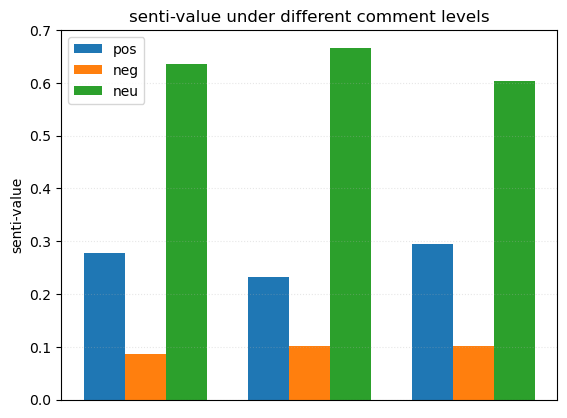

In [443]:
import matplotlib.pyplot as plt
import numpy as np

species = ("high", "mid", "low")

x = np.arange(len(species))  # the label locations


y1, y2, y3 = [], [] ,[]

for i in comments_score_results:
    y1.append(i[1])
    y2.append(i[2])
    y3.append(i[3])

width = 0.25  # the width of the bars

# fig, ax = plt.subplots(layout='constrained')



# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('sentiment')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.set_ylim(0, 250)
fig,ax=plt.subplots()

p1=ax.bar(x-0.25, y1, width,label='pos')
p2=ax.bar(x, y2, width,label='neg')
p3=ax.bar(x+0.25, y3, width,label='neu')

# ax.bar_label(p1,label_type='edge')
plt.ylabel('senti-value')
plt.xticks([])
plt.title('senti-value under different comment levels')
plt.grid(alpha=0.3,linestyle=':')
plt.legend()
plt.savefig('subpopulation.png', bbox_inches='tight')
plt.show()